In [1]:
import tensorflow as tf
print(tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PILhttps://colab.research.google.com/github/hseghetto/PICME-Deep-Learning/blob/main/conditional_gan.ipynb
from tensorflow.keras import layers
import time

from IPython import display

2.10.1


#Loading dataset


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_labels_onehot = np.eye(10)[train_labels]

In [3]:
print(train_images.shape)
print('.')
print(train_labels.shape)
print(train_labels[0])
print('.')
print(train_labels_onehot.shape)
print(train_labels_onehot[0])

(60000, 28, 28, 1)
.
(60000,)
5
.
(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset_onehot = tf.data.Dataset.from_tensor_slices((train_images,train_labels_onehot)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [5]:
for images, labels in train_dataset:
    pass
print(images.shape)
print(labels.shape)


(96, 28, 28, 1)
(96,)


#Model

##Generator

In [6]:
def generator_model():
    input_shape = (noise_dim)
    noise = layers.Input(input_shape)

    label_dim = 7*7*64

    x = layers.Dense(7*7*128-label_dim, use_bias = False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    label = layers.Input(1)

    y = layers.Embedding(10,50)(label)
    y = layers.Dense(label_dim)(y)
    y = layers.Reshape([label_dim])(y)

    x = layers.Concatenate()([x,y])

    x = layers.Reshape((7,7,128))(x)

    #x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x) # 7x7x128 -> 14x14x128
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x) # 14x14x128 -> 28x28x64
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x) #to grayscale

    model = tf.keras.Model([noise,label],x)
    print("Generator model created succesfully")
    return model

In [7]:
noise = tf.random.normal([len(labels), 100])

gen = generator_model()
gen([noise,labels])
gen.summary()

tf.keras.utils.plot_model(gen,to_file="gen.png",show_shapes=True, show_dtype=True)

Generator model created succesfully
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 3136)         313600      ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                          

In [8]:
print(labels.shape)
labels[0]

(96,)


<tf.Tensor: shape=(), dtype=uint8, numpy=0>

##Discriminator

In [9]:
def discriminator_model():
    input_shape = (28,28,1,)
    image = layers.Input(input_shape)

    x = layers.Conv2D(1, (5, 5), strides=(1, 1), padding='same', use_bias=False)(image)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    label = layers.Input(1)

    y = layers.Embedding(10,50)(label)
    y = layers.Dense(28*28*1)(y)
    y = layers.Reshape((28,28,1))(y)

    x = layers.Concatenate()([x,y])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    model = tf.keras.Model([image,label],x)
    print("Discriminator model created succesfully")
    return model

In [10]:
disc = discriminator_model()
disc([images,labels])
disc.summary()

tf.keras.utils.plot_model(disc,to_file="disc.png",show_shapes=True, show_dtype=True)

Discriminator model created succesfully
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 1)    25          ['input_3[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_4[0][0]']                
                                                    

#Optimizer & Losses

In [11]:
#@tf.function
def generator_loss(fake_output):
    return tf.reduce_sum(fake_output)

In [12]:
#@tf.function
def discriminator_loss(real_output, fake_output, penalty = 0):
    return tf.reduce_sum(real_output - fake_output) + penalty

In [13]:
c = 0.1
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
#discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4,clipnorm = c) #using clipnorm to satisfy WGAN requirements
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4)

#generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.99, epsilon=1e-08)
#discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.99, epsilon=1e-08)

#Training Loop

In [14]:
noise_dim = 100
num_examples_to_generate = 16

LABEL_DIM = len(np.unique(train_labels))
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
noise = tf.random.normal([num_examples_to_generate, noise_dim])
labels = np.array(range(num_examples_to_generate))%LABEL_DIM
labels = tf.convert_to_tensor(labels,dtype=noise.dtype)

seed = (noise, labels)

### Train Step

In [15]:
@tf.function
def train_step(images,labels):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator((noise, labels), training=True)

        real_output = discriminator((images, labels), training=True)
        fake_output = discriminator((generated_images, labels), training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
@tf.function 
def train_step_gp(images,labels):
    noise = tf.random.normal([images.shape[0], noise_dim])
    e = tf.random.uniform([images.shape[0],1,1,1],minval = 0,maxval = 1)

    with tf.GradientTape(persistent=True) as tape:
        with tf.GradientTape() as penalty_tape:
            generated_images = generator((noise, labels), training=True)

            weighted_images = e*images + (1-e)*generated_images

            weighted_output = discriminator((weighted_images,labels), training = True)

        real_output = discriminator((images, labels), training = True)
        fake_output = discriminator((generated_images, labels), training = True)

        penalty = penalty_tape.gradient(weighted_output,weighted_images) #gradient
        penalty = tf.sqrt(tf.reduce_sum(tf.square(penalty), axis=[1, 2, 3])) #norm
        penalty = 100*tf.reduce_mean(tf.math.square(penalty-1)) # k*(norm -1)^2

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output, penalty)


    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Main Loop 

In [17]:
def generate_and_save_images(model, epoch, input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('nn_{}_step_{}_epoch_{:04d}.png'.format(NN,TRAIN,epoch))
  plt.show()

In [18]:
def train(dataset,Epochs):

    print("Starting training")
    for epoch in range(Epochs):
        start = time.time()

        #print("Epoch {}".format(epoch+1))

        for image_batch, label_batch in dataset:
            #print(".",end="")
            train_step_gp(image_batch, label_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,seed)
        
        print ("Time for epoch {}/{} is {} sec".format(epoch + 1,Epochs, time.time()-start))

#Model training

In [19]:
try:
    NN = NN + 0
except:
    NN = 0

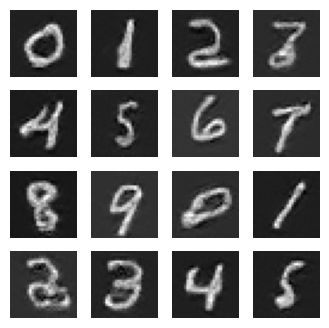

Time for epoch 50/50 is 29.732203483581543 sec


In [20]:
NN = NN +1
TRAIN = 0

generator = generator_model()
discriminator = discriminator_model()

train(train_dataset,50)
TRAIN = TRAIN+1

In [21]:
print(seed[1])

tf.Tensor([0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 0. 1. 2. 3. 4. 5.], shape=(16,), dtype=float32)


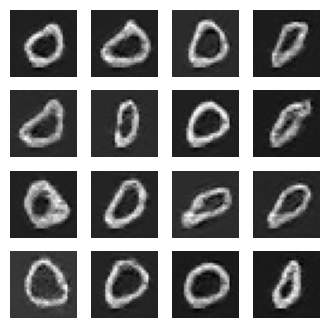

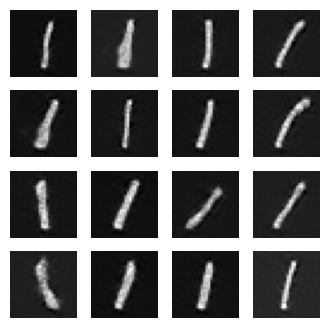

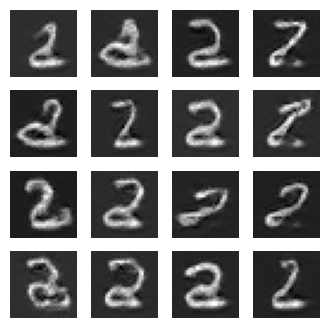

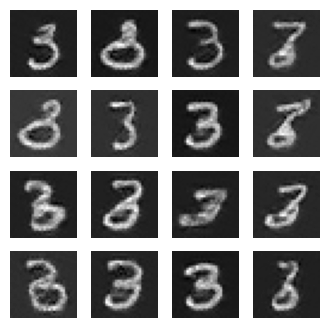

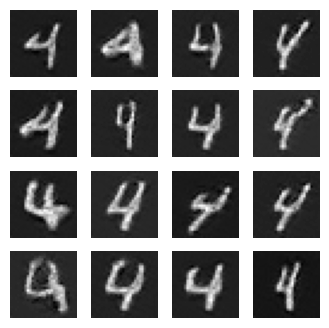

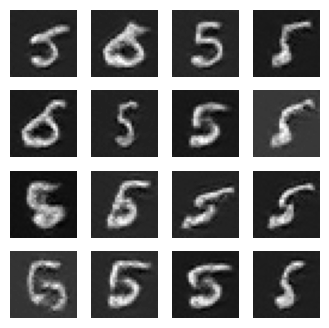

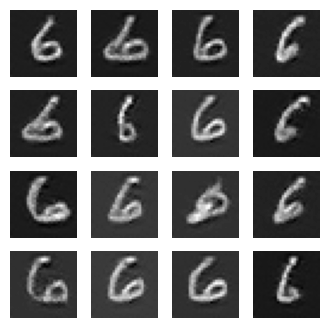

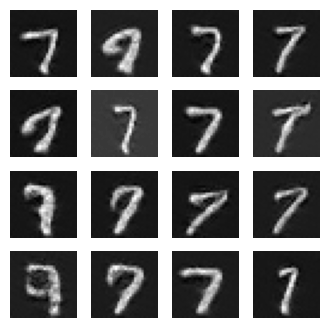

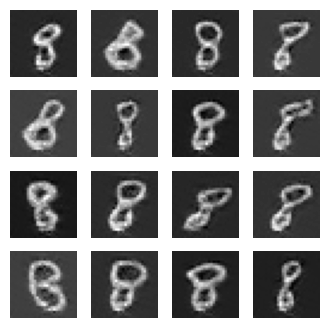

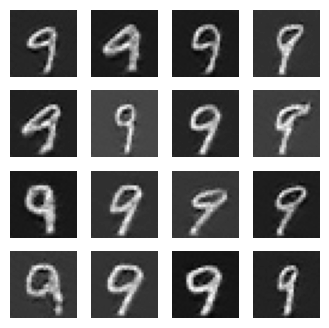

In [22]:
for i in range(10):
    seed = (noise,tf.ones(num_examples_to_generate)*i)

    predictions = generator(seed, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()
